This is the notebook for paper [**A New Approach to Generate Individual Level Data of Walled Garden Platforms: Linear Programming Reconstruction**](https://openreview.net/forum?id=VVYnNKUzdH&noteId=LfpcKintW9) in NeurIPS 2024 Workshop Behavioral ML. No data will be released due to privacy regulations. This notebook will simulate data as the ground truth data (hidden data in Figure 1), and then show the reconstruction method as well as evaluation.


# PART1 Generate simulated data

Real-world data cannot be released due to privacy regulations. Instead, we simulate data using key statistics of real-world data in experiments.

### 1.1 Random Generate touchpoint dates and conversion date

**Three key given statistics:**
- Average number of channels touched per person (0 as non-converted, 1 as converted),
- Percentage of channel touched per person (0 as non-converted, 1 as converted),
- Average touchpoint counts for each channel per person (0 as non-converted, 1 as converted).

Random date generation:
- Random conversion date from a range
- Touchpoints date are randomly generated between the first date and the conversion date.


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Define the average channel count statistics, average number of channels touched per person (0 as non-converted, 1 as converted)
average_channel_count = {
    'converted': {0: 0.75, 1: 1.59}
}

# Simulate the conversion status
n_users = 3000 # total number of users
conversion_status = np.random.choice([0, 1], size=n_users, p=[0.7, 0.3]) # assign conversion status with probability p

# Create a DataFrame to store the simulated data
simulated_data = pd.DataFrame({'Conversion Status': conversion_status})

# these can be changed based on given statistics, the percentage of channel touched per person
path_touched_percentage = {
    'DISPLAY': {0: 0.02, 1: 0.25},
    'YT': {0: 0.03, 1: 0.05},
    'EMAIL': {0: 0.11, 1: 0.13},
    'FB': {0: 0.28, 1: 0.35},
    'PS': {0: 0.01, 1: 0.25}
}

# a simple method to normalize the probabilities, do not need to be precise here
precomputed_probabilities = {}
for status in [0, 1]:
    channels = list(path_touched_percentage.keys())
    probabilities = [path_touched_percentage[channel][status] for channel in channels]

    # deal with probabilities with respect to each touch
    probabilities = [p / average_channel_count['converted'][status] for p in probabilities]

    total_prob = sum(probabilities)
    if total_prob >= 1:
        normalized_probabilities = [p / total_prob for p in probabilities]
    if total_prob < 1:
        other_channel_prob = 1 - total_prob
        num_other_channels = 5 # a guessing of uncounted channels
        for i in range(num_other_channels):
            channels.append(f"OTHER_{i+1}")
            probabilities.append(other_channel_prob / num_other_channels)
        # other_channel_prob = 1 - total_prob
        # channels.append("OTHER")
        # probabilities.append(other_channel_prob)
    precomputed_probabilities[status] = {
        'channels': channels,
        'probabilities': [p / sum(probabilities) for p in probabilities]
    }

# Function to generate channels for each user based on the number of channels they have and the conversion status
def generate_channels(row):
    conversion_status = row['Conversion Status']

    # generate the number of channels touched per person by Poisson distribution
    num_channels = int(np.random.poisson(average_channel_count['converted'][conversion_status]))
    if num_channels == 0:
        return []

    # get probability from pre computation
    channels = precomputed_probabilities[conversion_status]['channels']
    probabilities = precomputed_probabilities[conversion_status]['probabilities']

    # max number of channels should no more than the number of channels
    available_channels = len(channels)
    if num_channels > available_channels:
        num_channels = available_channels

    # weighted random choice to get all touched channels
    touched_channels = np.random.choice(channels, size=num_channels, replace=False, p=probabilities).tolist()

    # remove "OTHER" channel
    touched_channels = [channel for channel in touched_channels if not channel.startswith("OTHER")]

    return touched_channels

# randomly generate touched channels for each user
simulated_data['Channels'] = simulated_data.apply(generate_channels, axis=1)


# these can be changed based on given statistics
# Average touchpoint counts for each channel per person
average_touchpoint_count = {
    ('DISPLAY', 0): 0.9836,
    ('DISPLAY', 1): 7.3402,
    ('EMAIL', 0): 3.3404,
    ('EMAIL', 1): 4.2781,
    ('FB', 0): 0.4334,
    ('FB', 1): 0.4563,
    ('PS', 0): 0.0181,
    ('PS', 1): 0.4220,
    ('YT', 0): 0.0505,
    ('YT', 1): 0.2602
}

# Function to generate touchpoints for each channel based on the average touchpoint count statistics
def generate_touchpoints(row):
    channels = row['Channels']
    touchpoints = {}
    for channel in channels:
        avg_count = average_touchpoint_count[(channel, row['Conversion Status'])]
        avg_count = avg_count / path_touched_percentage[channel][row['Conversion Status']]
        # generate at least one touchpoint 
        num_touchpoints = np.random.poisson(avg_count-1)+1
        # num_touchpoints = np.random.poisson(avg_count)
        touchpoints[channel] = num_touchpoints
    return touchpoints

# Generating touchpoint countss for each user
simulated_data['Touchpoints'] = simulated_data.apply(generate_touchpoints, axis=1)

# date range, this can be changed based on the needs
start_date = datetime(2018, 6, 1)
end_date = datetime(2018, 6, 30)

# randomly generate am array of dates between the start and end
def generate_random_dates(num_dates, start_date, end_date):
    delta = end_date - start_date
    dates = [start_date + timedelta(days=np.random.randint(0, delta.days + 1)) for _ in range(num_dates)]
    dates = pd.to_datetime(dates).sort_values(ascending=False).to_list()
    return [date.date() for date in dates]

# Generat3 conversion dates for conversion=1 users
conversion_dates = {}
for idx, row in simulated_data.iterrows():
    if row['Conversion Status'] == 1:
        conversion_dates[idx] = end_date - timedelta(days=np.random.randint(0, 7))

# Generate touchpoints date according to touchpoint counts
for idx, row in simulated_data.iterrows():
    touchpoints = row['Touchpoints']
    if row['Conversion Status'] == 1 and idx in conversion_dates:
        conversion_date = conversion_dates[idx]
        for channel, num_touches in touchpoints.items():
            random_dates = generate_random_dates(num_touches, start_date, conversion_date - timedelta(days=1))
            touchpoints[channel] = random_dates
        simulated_data.at[idx, 'Conversion Date'] = conversion_date.date()
    else:
        for channel, num_touches in touchpoints.items():
            random_dates = generate_random_dates(num_touches, start_date, end_date)
            touchpoints[channel] = random_dates

# Randomly generate demographic information, could be integrated later
# age_groups = ['0-18', '19-24', '24-30', '30-36', '36-45', '45-55', '55+']
# simulated_data['Age Group'] = np.random.choice(age_groups, size=len(simulated_data))

# continents = ['Asia', 'Europe', 'America', 'Africa', 'Australia']
# simulated_data['Continent'] = np.random.choice(continents, size=len(simulated_data))

# genders = ['Male', 'Female']
# simulated_data['Gender'] = np.random.choice(genders, size=len(simulated_data))

# # simulated_data = simulated_data[simulated_data['Touchpoints'].apply(lambda x: any(x.values()))]

# print("\nSimulated Data with Touchpoints:")
simulated_data.to_csv('simulation_data.csv', index=False)
simulated_data

,Conversion Status,Channels,Touchpoints,Conversion Date
0,0,[EMAIL],"{'EMAIL': [2018-06-30, 2018-06-29, 2018-06-28,...",NaN
1,1,"[EMAIL, FB, DISPLAY]","{'EMAIL': [2018-06-25, 2018-06-25, 2018-06-25,...",2018-06-26
2,0,[],{},NaN
3,0,[],{},NaN
4,0,[YT],"{'YT': [2018-06-22, 2018-06-01]}",NaN
...,...,...,...,...
2995,0,[],{},NaN
2996,0,"[FB, EMAIL]","{'FB': [2018-06-07], 'EMAIL': [2018-06-30, 201...",NaN
2997,0,[],{},NaN
2998,1,"[PS, FB, DISPLAY]","{'PS': [2018-06-16, 2018-06-02], 'FB': [2018-0...",2018-06-30


## 1.2 Three Given Statistics

Compute the basic statistics of simulated data.

**Simulated data serve as the ground truth data (hidden data)**, then we will try to reconstruct these data.


In [12]:
import pandas as pd

data = simulated_data.copy()

# clean null (key, value) pair
def clean_touchpoints(touchpoints):
    return {k: v for k, v in touchpoints.items() if v}

data['Touchpoints'] = data['Touchpoints'].apply(clean_touchpoints)

# get channel count per person
data['Channels'] = data['Touchpoints'].apply(lambda x: list(x.keys()))
data['Channel_Count'] = data['Channels'].apply(len)

average_channel_count_converted = data[data['Conversion Status'] == 1]['Channel_Count'].mean()
average_channel_count_not_converted = data[data['Conversion Status'] == 0]['Channel_Count'].mean()

print(f"Converted: {average_channel_count_converted}")
print(f"Not Converted: {average_channel_count_not_converted}")

# channel list
channels = ['DISPLAY', 'EMAIL', 'FB', 'PS', 'YT']

path_touched_percentage = {channel: {0: 0, 1: 0} for channel in channels}
average_touchpoint_count = {(channel, status): 0 for channel in channels for status in [0, 1]}

# statistics
for channel in channels:
    for status in [0, 1]:
        # filter data with certain channel
        filtered_data = data[(data['Channels'].apply(lambda x: channel in x)) & (data['Conversion Status'] == status)]
        total_users = len(filtered_data)

        # average path touch percentage
        if total_users > 0:
            path_touched_percentage[channel][status] = total_users / len(data[data['Conversion Status'] == status])

        # average touchpoint count
        if total_users > 0:
            total_touchpoints = 0
            for touchpoints in filtered_data['Touchpoints']:
                total_touchpoints += len(touchpoints.get(channel, []))
            average_touchpoint_count[(channel, status)] = total_touchpoints / len(data[data['Conversion Status'] == status])

path_touched_percentage_df = pd.DataFrame(path_touched_percentage)

print("\nPath Touched Percentage:")
print(path_touched_percentage_df)
print("\nAverage Touchpoint Count:")

average_touchpoint_count_df = pd.DataFrame(list(average_touchpoint_count.items()), columns=['Channel_Status', 'Average_Touchpoint_Count'])
average_touchpoint_count_df[['Channel', 'Status']] = pd.DataFrame(average_touchpoint_count_df['Channel_Status'].tolist(), index=average_touchpoint_count_df.index)

average_touchpoint_count_df.drop('Channel_Status', axis=1, inplace=True)
average_touchpoint_count_df.set_index(['Channel', 'Status'], inplace=True)
print(average_touchpoint_count_df)


Converted: 1.0232300884955752
Not Converted: 0.41841603053435117

Path Touched Percentage:
    DISPLAY     EMAIL        FB        PS        YT
0  0.023855  0.116412  0.236164  0.012882  0.029103
1  0.242257  0.139381  0.323009  0.262168  0.056416

Average Touchpoint Count:
                Average_Touchpoint_Count
Channel Status                          
DISPLAY 0                       1.195134
        1                       6.930310
EMAIL   0                       3.594466
        1                       4.485619
FB      0                       0.366412
        1                       0.418142
PS      0                       0.019561
        1                       0.425885
YT      0                       0.046279
        1                       0.285398


## 1.3 Walled Garden Statistics

**Walled Garden Statistics of simulated data**:

The samples of these statistics is (conversion number for all channels, then the rest statistics are for each channel):

| Date       | # conversion | # touchpoints | Lag1 count | Lag2 count | ... | Lag 30 count |
|------------|--------------|---------------|------------|------------|-----|---------------|
| 2018/6/30 | 470          | 91            | 10         | 8          | ... | 1             |
| 2018/6/29 |  361     | 122 | 15 | 20 | ... | 0 |
| 2018/6/28 | ... | ... | ... | ... | ... | ... |
| ... | ... | ... | ... | ... | ... | ... |


In [3]:
# generation of Walled Garden statistics

import pandas as pd
from collections import defaultdict

# date range
date_range = pd.date_range(start="2018-06-01", end="2018-06-30").date
convert_date_range = pd.date_range(start="2018-06-01", end="2018-06-30").date

# set walled garden channels, can be changed based on your needs
channels = ['FB', 'YT']

# dictionary initialization
preprocessed_data = defaultdict(lambda: defaultdict(list))
conversion_counts = defaultdict(int)
daily_touchpoints = defaultdict(lambda: defaultdict(int))

# pre process simulated_data，get all touch points into preprocessed_data
for idx, row in simulated_data.iterrows():
    if row['Conversion Status'] == 1:
        conversion_date = pd.to_datetime(row['Conversion Date']).date()
        conversion_counts[conversion_date] += 1
        for channel, dates in row['Touchpoints'].items():
            if channel in channels:
                for date in dates:
                    date = pd.to_datetime(date).date()
                    preprocessed_data[conversion_date][channel].append(date)

    # the number of touchpoint each day
    for channel, dates in row['Touchpoints'].items():
        for date in dates:
            date = pd.to_datetime(date).date()
            daily_touchpoints[date][channel] += 1

# statistics
data = {'Date': convert_date_range}
for channel in channels:
    data[f'{channel} #conversion'] = [0] * len(convert_date_range)
    data[f'{channel} #touchpoints'] = [0] * len(convert_date_range)
    for i in range(1, 31):
        data[f'{channel} Lag{i} count'] = [0] * len(convert_date_range)

statistics = pd.DataFrame(data)
statistics.set_index('Date', inplace=True)

# generate the statistics
for conversion_date in convert_date_range:
    conversion_count = conversion_counts[conversion_date]
    for channel in channels:
        touchpoints = preprocessed_data[conversion_date][channel]
        touchpoints_count = daily_touchpoints[conversion_date][channel]
        lag_counts = [0] * 30

        for date in touchpoints:
            lag = (conversion_date - date).days
            if 1 <= lag <= 30:
                lag_counts[lag - 1] += 1

        statistics.at[conversion_date, f'{channel} #conversion'] = conversion_count
        statistics.at[conversion_date, f'{channel} #touchpoints'] = touchpoints_count
        for i in range(1, 31):
            statistics.at[conversion_date, f'{channel} Lag{i} count'] = lag_counts[i - 1]

# convert NaN to int
statistics = statistics.fillna(0).astype(int)

# sort from back to forward
statistics = statistics.sort_index(ascending=False)

# save
statistics.to_csv('walled_garden_combined_statistics.csv', index=True)
statistics


,FB #conversion,FB #touchpoints,FB Lag1 count,FB Lag2 count,FB Lag3 count,FB Lag4 count,FB Lag5 count,FB Lag6 count,FB Lag7 count,FB Lag8 count,...,YT Lag21 count,YT Lag22 count,YT Lag23 count,YT Lag24 count,YT Lag25 count,YT Lag26 count,YT Lag27 count,YT Lag28 count,YT Lag29 count,YT Lag30 count
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-30,130,23,4,0,1,2,4,1,1,1,...,2,1,3,2,0,2,1,1,2,0
2018-06-29,135,32,3,5,2,1,2,2,3,1,...,2,1,1,0,1,4,2,2,0,0
2018-06-28,128,29,2,2,3,4,0,1,1,1,...,2,3,3,2,2,1,1,0,0,0
2018-06-27,127,33,4,6,4,0,3,2,3,3,...,0,2,0,3,0,3,0,0,0,0
2018-06-26,125,35,3,3,0,3,3,1,2,3,...,4,0,1,1,0,0,0,0,0,0
2018-06-25,129,34,3,6,2,0,3,1,1,2,...,1,1,0,1,0,0,0,0,0,0
2018-06-24,130,39,6,2,2,1,1,2,4,2,...,2,1,0,0,0,0,0,0,0,0
2018-06-23,0,40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-06-22,0,40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1.4 Non Walled Garden channels' data

Here we remove Walled Garden channels' data, then got the non Walled Garden channels' data to release.

In [4]:
import copy

# deep copy the simulated dataframe
def deep_copy(df):
    new_df = pd.DataFrame(columns=df.columns)
    new_rows = []
    for idx, row in df.iterrows():
        new_row = row.copy()
        new_row['Touchpoints'] = copy.deepcopy(row['Touchpoints'])  # deepcopy each key value
        new_rows.append(new_row)

    new_df = pd.concat([new_df, pd.DataFrame(new_rows)], ignore_index=True)
    return new_df

re_simulated_data = deep_copy(simulated_data)

# Walled Garden channels
channels_to_reconstruct = ['FB', 'YT']
for idx, row in re_simulated_data.iterrows():
    for channel in channels_to_reconstruct:
        if channel in row['Touchpoints']:
            row['Touchpoints'][channel] = []

re_simulated_data['Touchpoints'] = re_simulated_data['Touchpoints'].apply(clean_touchpoints)
re_simulated_data['Channels'] = re_simulated_data['Touchpoints'].apply(lambda x: list(x.keys()))

re_simulated_data

,Conversion Status,Channels,Touchpoints,Conversion Date
0,0,[EMAIL],"{'EMAIL': [2018-06-30, 2018-06-29, 2018-06-28,...",NaN
1,1,"[EMAIL, DISPLAY]","{'EMAIL': [2018-06-25, 2018-06-25, 2018-06-25,...",2018-06-26
2,0,[],{},NaN
3,0,[],{},NaN
4,0,[],{},NaN
...,...,...,...,...
2995,0,[],{},NaN
2996,0,[EMAIL],"{'EMAIL': [2018-06-30, 2018-06-28, 2018-06-27,...",NaN
2997,0,[],{},NaN
2998,1,"[PS, DISPLAY]","{'PS': [2018-06-16, 2018-06-02], 'DISPLAY': [2...",2018-06-30


# PART 2 Reconstruction

In this part, we reconstruct the ground truth data (simulated data). We have (these data can be seen as released):
- non Walled Garden channels' individual data (1.4)
- Walled Garden statistics of Walled Garden channels (1.3)
- path touch percentage statistics of Walled Garden channels. (1.2)

Our objective:
- reconstruct data based on the released information to approximate simulated data


Here we show how to reconstruct individual data using Linear Programming with released statistics.



First, install pulp library for linear programming

In [ ]:
!pip install pulp

## 2.1 Linear Programming Reconstruction

According to Chapter 3.1, we reconstruct how many touches per user per date on each Walled Garden channels using linear programming. Linear Programming solutions are floats by default, we use probabilistic rounding to convert them to integers.

In [30]:
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpStatus, value, LpInteger, LpBinary, LpMaximize
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import time

random.seed(time.time())

# probabilistic rounding, refer to Equation 1
def probabilistic_round(value):
    random.seed(time.time())
    floor_value = int(np.floor(value))
    decimal_part = value - floor_value
    if random.random() < decimal_part:
        return floor_value + 1
    else:
        return floor_value

num_conversion_users = np.sum(re_simulated_data['Conversion Status'])
num_users = len(re_simulated_data)
num_nonconversion_users = num_users - num_conversion_users

# set path touch percentage from statistics in 1.2, copy the value here
# Path Touched Percentage:
#     DISPLAY     EMAIL        FB        PS        YT
# 0  0.023855  0.116412  0.236164  0.012882  0.029103
# 1  0.242257  0.139381  0.323009  0.262168  0.056416
path_touches_real_percentage = {
    'FB': {0:0.236164  , 1:0.323009  },
    'YT': {0:0.029103  , 1:0.056416  }
}

# path touch percentage error bound in linear programming
gap = 0.02

channels_to_reconstruct = ['FB', 'YT']
days = range(1, 31)

# store linear programming solution (floating numbers)
click_vars_global = {}

for channel in channels_to_reconstruct:
    # set max number of clicks per user per date per channel, could be changed (based on common sense)
    max_clicks_per_day = 2
    daily_purchases = statistics[f"{channel} #conversion"].tolist()
    daily_clicks = statistics[f"{channel} #touchpoints"].tolist()
    clicks_before_purchase = statistics[[f'{channel} Lag{i} count' for i in range(1, 31)]].values

    clicks_before_purchase = clicks_before_purchase[::-1]
    daily_purchases = daily_purchases[::-1]
    daily_clicks = daily_clicks[::-1]
    convert_days = np.unique([day for day, count in enumerate(daily_purchases, start=1) if count > 0])

    # define LP problem, Minimize errors
    problem = LpProblem("Ad_Clicks_and_Purchases_Reconstruction", LpMinimize)

    num_users = re_simulated_data.shape[0]

    # could set solution to integers, but will too slow to be infeasible
    # click_vars = {(user, day): LpVariable(f"click_{user}_{day}", lowBound=0, cat=LpInteger) for user in range(num_users) for day in days}

    # set solution vars, statistics deviation, and max deviation for this channel
    click_vars = {(user, day): LpVariable(f"click_{user}_{day}", lowBound=0) for user in range(num_users) for day in days}
    click_deviation = {day: LpVariable(f"click_deviation_{day}", lowBound=0) for day in days}
    click_before_deviation = {(day, prev_day): LpVariable(f"click_before_deviation_{day}_{prev_day}", lowBound=0) for day in days for prev_day in range(1, 31)}
    max_deviation = LpVariable("max_deviation", lowBound=0)

    # set max_deviation to be larger than click errors per day
    for day in days:
        problem += max_deviation >= click_deviation[day]

    # set click_deviations >= abs(error on this date)
    for day in days:
        problem += lpSum(click_vars[user, day] for user in range(num_users)) - daily_clicks[day-1] <= click_deviation[day]
        problem += daily_clicks[day-1] - lpSum(click_vars[user, day] for user in range(num_users)) <= click_deviation[day]

    # set click_before_deviation (statistics in Walled Garden statistics) and max_deviation to be larger than them
    for day in convert_days:
        for prev_day in range(1, day):
            conversion_date = (pd.to_datetime('2018-06-01') + pd.DateOffset(days=int(day)-1)).date()
            problem += lpSum(click_vars[user, prev_day] for user in range(num_users) if re_simulated_data.at[user, 'Conversion Status'] == 1 and re_simulated_data.at[user, 'Conversion Date'] == conversion_date) - clicks_before_purchase[day-1][prev_day-1] <= click_before_deviation[(day, prev_day)]
            problem += clicks_before_purchase[day-1][prev_day-1] - lpSum(click_vars[user, prev_day] for user in range(num_users) if re_simulated_data.at[user, 'Conversion Status'] == 1 and re_simulated_data.at[user, 'Conversion Date'] == conversion_date) <= click_before_deviation[(day, prev_day)]
            problem += max_deviation >= click_before_deviation[(day, prev_day)]

    # set other values to be 0 (these will not count into statistics, like touches after conversion |we do not consider this in this contect| )
    for user in range(num_users):
        if re_simulated_data.at[user, 'Conversion Status'] == 1:
            purchase_date = (pd.to_datetime(re_simulated_data.at[user, 'Conversion Date']) - pd.to_datetime('2018-06-01')).days + 1
            for day in range(purchase_date, 31):
                click_vars[user, day].setInitialValue(0)
                click_vars[user, day].fixValue()

    # this could be set for each channel
    for user in range(num_users):
        for day in days:
            if channel == 'FB':
                problem += click_vars[user, day] <= max_clicks_per_day
            elif channel == 'YT':
                problem += click_vars[user, day] <= max_clicks_per_day

    
    # below, we introduce path touch percentage to better distribute touchpoints, this is a subtle design!

    # define the probability p one user has clicks in this channel, if the expected click number > 1, then p = 1, else, p = expected click number (floating numbers) 
    # this is vital to maintain path touch percentage!!!
    click_user_vars = {user: LpVariable(f"click_user_{user}", lowBound=0) for user in range(num_users)}
    # total clicks per user on this channel
    total_clicks = {user: LpVariable(f"total_clicks_{user}", lowBound=0) for user in range(num_users)}
    # indicator vars, binary!!!!!
    indicator_vars = {user: LpVariable(f"indicator_{user}", cat=LpBinary) for user in range(num_users)}

    # calculate total clikes per user
    for user in range(num_users):
        problem += total_clicks[user] == lpSum(click_vars[user, day] for day in days)

    # subtle design!
    # refer to Big M method: https://en.wikipedia.org/wiki/Big_M_method
    # solve click_user_vars[user]
    for user in range(num_users):
        # add indicator vars
        problem += total_clicks[user] - 1 <= indicator_vars[user] * 1000
        problem += total_clicks[user] >= indicator_vars[user]

        # if total_clicks[user] > 1 -> indicator_vars[user] = 1, click_user_vars[user] = 1
        problem += click_user_vars[user] >= indicator_vars[user]
        problem += click_user_vars[user] <= 1

        # if total_clicks[user] <= 1 -> indicator_vars[user] = 0, click_user_vars[user] = total_clicks[user]
        problem += click_user_vars[user] <= total_clicks[user]
        problem += click_user_vars[user] >= total_clicks[user] - indicator_vars[user] * 1000


    # compute the number of users touching this channel based on probability, make the error less than "gap" for converted and non-converted users
    problem += lpSum(click_user_vars[user] for user in range(num_users) if re_simulated_data.at[user, 'Conversion Status'] == 1) >= (path_touches_real_percentage[channel][1])* (1 - gap) * num_conversion_users
    problem += lpSum(click_user_vars[user] for user in range(num_users) if re_simulated_data.at[user, 'Conversion Status'] == 1) <= (path_touches_real_percentage[channel][1])* (1 + gap) * num_conversion_users

    problem += lpSum(click_user_vars[user] for user in range(num_users) if re_simulated_data.at[user, 'Conversion Status'] == 0) >= (path_touches_real_percentage[channel][0])* (1 - gap) * num_nonconversion_users
    problem += lpSum(click_user_vars[user] for user in range(num_users) if re_simulated_data.at[user, 'Conversion Status'] == 0) <= (path_touches_real_percentage[channel][0])* (1 + gap) * num_nonconversion_users

    # Minimize max_deviation
    problem += max_deviation

    # solve the problem
    problem.solve()
    print(f"Channel: {channel}, Max Deviation: {value(max_deviation)}, Status: {LpStatus[problem.status]}")

    # store the solution into this dictionary! so we may reuse later if needed
    for user in range(num_users):
        for day in days:
            var_name = f"click_{channel}_{user}_{day}"
            click_vars_global[(channel, user, day)] = click_vars[(user, day)]

    # the base start date of the data, hard-code
    base_date = pd.to_datetime('2018-06-01')

    # probabilistics rounding, better than simply round
    reconstructed_clicks = {user: [probabilistic_round(value(click_vars[user, day])) for day in days] for user in range(num_users)}

    # convert reconstructed clicks into re_simulated_data
    for user in range(num_users):
        click_dates = []
        for day, clicks in enumerate(reconstructed_clicks[user], start=1):
            # convert click numbers into the same number of dates
            click_dates.extend([base_date + timedelta(days=day-1)] * int(clicks))

        # update re_simulated_data
        if click_dates:
            re_simulated_data.at[user, 'Touchpoints'][channel] = [date.date() for date in sorted(click_dates)]
        else:
            re_simulated_data.at[user, 'Touchpoints'][channel] = []

re_simulated_data.to_csv('final_reconstructed_data.csv', index=False)

re_simulated_data

Channel: FB, Max Deviation: 0.0, Status: Optimal
Channel: YT, Max Deviation: 0.42857143, Status: Optimal


,Conversion Status,Channels,Touchpoints,Conversion Date
0,0,[EMAIL],"{'EMAIL': [2018-06-30, 2018-06-29, 2018-06-28,...",NaN
1,1,"[EMAIL, DISPLAY]","{'EMAIL': [2018-06-25, 2018-06-25, 2018-06-25,...",2018-06-26
2,0,[],"{'FB': [2018-06-09], 'YT': []}",NaN
3,0,[],"{'FB': [2018-06-30], 'YT': []}",NaN
4,0,[],"{'FB': [], 'YT': []}",NaN
...,...,...,...,...
2995,0,[],"{'FB': [], 'YT': []}",NaN
2996,0,[EMAIL],"{'EMAIL': [2018-06-30, 2018-06-28, 2018-06-27,...",NaN
2997,0,[],"{'FB': [], 'YT': []}",NaN
2998,1,"[PS, DISPLAY]","{'PS': [2018-06-16, 2018-06-02], 'DISPLAY': [2...",2018-06-30


### Re-round LP solution (floating number)

Redo the probabilistic rounding of the LP solutions if you want.

Usually when post-processing does not work well, you may try to re-round the solution for a slight different re_simulated_data.

In [56]:
import time
random.seed(time.time())

for channel in channels_to_reconstruct:
    # probabilistics rounding, better than simply round
    reconstructed_clicks = {user: [probabilistic_round(value(click_vars_global[(channel, user, day)])) for day in days] for user in range(num_users)}

    # convert reconstructed clicks into re_simulated_data
    for user in range(num_users):
        click_dates = []
        for day, clicks in enumerate(reconstructed_clicks[user], start=1):
            # convert click numbers into the same number of dates
            click_dates.extend([base_date + timedelta(days=day-1)] * int(clicks))

        # update re_simulated_data
        if click_dates:
            re_simulated_data.at[user, 'Touchpoints'][channel] = [date.date() for date in sorted(click_dates)]
        else:
            re_simulated_data.at[user, 'Touchpoints'][channel] = []

re_simulated_data.to_csv('final_reconstructed_data.csv', index=False)

re_simulated_data

,Conversion Status,Channels,Touchpoints,Conversion Date
0,0,[EMAIL],"{'EMAIL': [2018-06-30, 2018-06-29, 2018-06-28,...",NaN
1,1,"[EMAIL, DISPLAY]","{'EMAIL': [2018-06-25, 2018-06-25, 2018-06-25,...",2018-06-26
2,0,[],"{'FB': [2018-06-09], 'YT': []}",NaN
3,0,[],"{'FB': [2018-06-30], 'YT': []}",NaN
4,0,[],"{'FB': [], 'YT': []}",NaN
...,...,...,...,...
2995,0,[],"{'FB': [], 'YT': []}",NaN
2996,0,[EMAIL],"{'EMAIL': [2018-06-30, 2018-06-28, 2018-06-27,...",NaN
2997,0,[],"{'FB': [], 'YT': []}",NaN
2998,1,"[PS, DISPLAY]","{'PS': [2018-06-16, 2018-06-02], 'DISPLAY': [2...",2018-06-30


### 2.1.1 Statictis Analysis

We do a simple comparson on three statisics of reconstructed data with that of the ground truth data.

In [62]:
import pandas as pd

# re_simulated_data is reconstructed data
data = re_simulated_data.copy()

def clean_touchpoints(touchpoints):
    return {k: v for k, v in touchpoints.items() if v}

data['Touchpoints'] = data['Touchpoints'].apply(clean_touchpoints)

data['Channels'] = data['Touchpoints'].apply(lambda x: list(x.keys()))
data['Channel_Count'] = data['Channels'].apply(len)

average_channel_count_converted = data[data['Conversion Status'] == 1]['Channel_Count'].mean()
average_channel_count_not_converted = data[data['Conversion Status'] == 0]['Channel_Count'].mean()

print(f"Converted: {average_channel_count_converted}")
print(f"Not Converted: {average_channel_count_not_converted}")

channels = ['DISPLAY', 'EMAIL', 'FB', 'PS', 'YT']


re_path_touched_percentage_df = {channel: {0: 0, 1: 0} for channel in channels}
re_average_touchpoint_count = {(channel, status): 0 for channel in channels for status in [0, 1]}

for channel in channels:
    for status in [0, 1]:
        # filter data with certain channel
        filtered_data = data[(data['Channels'].apply(lambda x: channel in x)) & (data['Conversion Status'] == status)]
        total_users = len(filtered_data)

        # average path touch percentage
        if total_users > 0:
            re_path_touched_percentage_df[channel][status] = total_users / len(data[data['Conversion Status'] == status])

        # average touchpoint count
        if total_users > 0:
            total_touchpoints = 0
            for touchpoints in filtered_data['Touchpoints']:
                total_touchpoints += len(touchpoints.get(channel, []))
            re_average_touchpoint_count[(channel, status)] = total_touchpoints / len(data[data['Conversion Status'] == status])

re_path_touched_percentage_df = pd.DataFrame(re_path_touched_percentage_df)

print("\nre Path Touched Percentage:")
print(re_path_touched_percentage_df)
print("\nre Average Touchpoint Count:")

re_average_touchpoint_count_df = pd.DataFrame(list(re_average_touchpoint_count.items()), columns=['Channel_Status', 'Average_Touchpoint_Count'])

re_average_touchpoint_count_df[['Channel', 'Status']] = pd.DataFrame(re_average_touchpoint_count_df['Channel_Status'].tolist(), index=re_average_touchpoint_count_df.index)

re_average_touchpoint_count_df.drop('Channel_Status', axis=1, inplace=True)
re_average_touchpoint_count_df.set_index(['Channel', 'Status'], inplace=True)
print(re_average_touchpoint_count_df)


print("\n(re-simu) Path Touched Percentage:")
diff_path_touch_percentage = re_path_touched_percentage_df - path_touched_percentage_df
print(diff_path_touch_percentage)

print("\n(re-simu) Average Touchpoint Count:")
diff_average_touchpoint_count = re_average_touchpoint_count_df - average_touchpoint_count_df
print(diff_average_touchpoint_count)

Converted: 1.0232300884955752
Not Converted: 0.4145992366412214

re Path Touched Percentage:
    DISPLAY     EMAIL        FB        PS        YT
0  0.023855  0.116412  0.232347  0.012882  0.029103
1  0.242257  0.139381  0.323009  0.262168  0.056416

re Average Touchpoint Count:
                Average_Touchpoint_Count
Channel Status                          
DISPLAY 0                       1.195134
        1                       6.930310
EMAIL   0                       3.594466
        1                       4.485619
FB      0                       0.366412
        1                       0.418142
PS      0                       0.019561
        1                       0.425885
YT      0                       0.050573
        1                       0.285398

(re-simu) Path Touched Percentage:
   DISPLAY  EMAIL        FB   PS   YT
0      0.0    0.0 -0.003817  0.0  0.0
1      0.0    0.0  0.000000  0.0  0.0

(re-simu) Average Touchpoint Count:
                Average_Touchpoint_Count
C

## 2.2 Post-processing 

Accroding to Chapter 3.2.

###  2.2.1 Difference on statistics
We will try to analyze the differences of Walled Garden statistics for the ground truth data and reconstructed data, here we define a function to compute Walled Garden statistics (same to 1.3).

In [58]:
import pandas as pd
from collections import defaultdict

def WalledGardenStat(re_simulated_data):
    
    # date range, hard-code
    date_range = pd.date_range(start="2018-06-01", end="2018-06-30").date
    convert_date_range = pd.date_range(start="2018-06-01", end="2018-06-30").date
    channels = ['YT', 'FB']
      
    # dictionary initialization
    preprocessed_data = defaultdict(lambda: defaultdict(list))
    conversion_counts = defaultdict(int)
    daily_touchpoints = defaultdict(lambda: defaultdict(int))
    
    # pre process data，get all touch points into preprocessed_data
    for idx, row in re_simulated_data.iterrows():
        if row['Conversion Status'] == 1:
            conversion_date = pd.to_datetime(row['Conversion Date']).date()
            conversion_counts[conversion_date] += 1
            for channel, dates in row['Touchpoints'].items():
                if channel in channels:
                    for date in dates:
                        date = pd.to_datetime(date).date()
                        preprocessed_data[conversion_date][channel].append(date)
    
        # the number of touchpoint each day
        for channel, dates in row['Touchpoints'].items():
            for date in dates:
                date = pd.to_datetime(date).date()
                daily_touchpoints[date][channel] += 1
    
    # statistics
    data = {'Date': convert_date_range}
    for channel in channels:
        data[f'{channel} #conversion'] = [0] * len(convert_date_range)
        data[f'{channel} #touchpoints'] = [0] * len(convert_date_range)
        for i in range(1, 31):
            data[f'{channel} Lag{i} count'] = [0] * len(convert_date_range)
    
    re_statistics = pd.DataFrame(data)
    re_statistics.set_index('Date', inplace=True)
    
    # generate Walled Garden statistics
    for conversion_date in convert_date_range:
        conversion_count = conversion_counts[conversion_date]
        for channel in channels:
            touchpoints = preprocessed_data[conversion_date][channel]
            touchpoints_count = daily_touchpoints[conversion_date][channel]
            lag_counts = [0] * 30
    
            for date in touchpoints:
                lag = (conversion_date - date).days
                if 1 <= lag <= 30:
                    lag_counts[lag - 1] += 1
    
            re_statistics.at[conversion_date, f'{channel} #conversion'] = conversion_count
            re_statistics.at[conversion_date, f'{channel} #touchpoints'] = touchpoints_count
            for i in range(1, 31):
                re_statistics.at[conversion_date, f'{channel} Lag{i} count'] = lag_counts[i - 1]
    
    # NaN to int
    re_statistics = re_statistics.fillna(0).astype(int)
    
    # sort from back to forward
    re_statistics = re_statistics.sort_index(ascending=False)

    return re_statistics

# suppose we reuse simulated_data which we have got before
# get statistics
re_statistics = WalledGardenStat(re_simulated_data)
re_statistics.to_csv('re_walled_garden_combined_statistics.csv', index=True)


# suppose statistics (1.3) and re_statistics are already defined as in your provided code
# Calculate the differences between the two DataFrames for FB and YT
max_difference_fb = 0
max_difference_yt = 0
total_absdifference_fb = 0
total_absdifference_yt = 0
total_difference_fb = 0
total_difference_yt = 0

fb_diff_details = {}
yt_diff_details = {}

for column in statistics.columns:
    if 'FB' in column and 'touchpoints' not in column:
        diff = abs(statistics[column] - re_statistics[column])
        total_difference_fb += (statistics[column] - re_statistics[column]).sum()
        total_absdifference_fb += sum(diff)
        max_diff = diff.max()
        if max_diff > max_difference_fb:
            max_difference_fb = max_diff
            fb_diff_details = {'Date': diff.idxmax(), 'Column': column, 'Difference': max_diff}
    elif 'YT' in column and 'touchpoints' not in column:
        diff = abs(statistics[column] - re_statistics[column])
        total_difference_yt += (statistics[column] - re_statistics[column]).sum()
        total_absdifference_yt += sum(diff)
        max_diff = diff.max()
        if max_diff > max_difference_yt:
            max_difference_yt = max_diff
            yt_diff_details = {'Date': diff.idxmax(), 'Column': column, 'Difference': max_diff}

# Print the maximum differences for FB and YT
print("FB max difference in each entry：")
print(fb_diff_details)
print(total_absdifference_fb)
print(total_difference_fb)
print("YT max difference in each entry：")
print(yt_diff_details)
print(total_absdifference_yt)
print(total_difference_yt)
diff_statistics = re_statistics - statistics

FB max difference in each entry：
{'Date': datetime.date(2018, 6, 24), 'Column': 'FB Lag1 count', 'Difference': np.int64(5)}
258
0
YT max difference in each entry：
{'Date': datetime.date(2018, 6, 26), 'Column': 'YT Lag5 count', 'Difference': np.int64(4)}
196
8


### 2.2.2 Adjust the reconstruction data based on the difference

We address these discrepancies through postprocessing, either by reducing excesses or compensating for shortfalls. Maintain path touch percentage at the same time!!

**Mention**: we only adjust differences for **converted users** in section 2.2 (with more detailed information in Walled Garden statistics), but the nonconverted processing is similar.

In [60]:
import random
import time

re_statistics = WalledGardenStat(re_simulated_data)
diff_statistics = re_statistics - statistics

adapt_channels = ['FB', 'YT']

# these are used for tracking the statistics while adjusting
channel_click_users_count = {}
total_converted_people = {}
difference_people = {}

for channel in adapt_channels:
    # 1. filter converted users
    converted_users = re_simulated_data[re_simulated_data['Conversion Status'] == 1]

    # 2. compute touch counts
    channel_click_counts = converted_users['Touchpoints'].apply(lambda x: len(x[channel]) if channel in x else 0)

    # 3. count the number of users touchping the channel
    channel_click_users_count[channel] = (channel_click_counts > 0).sum()
    total_converted_people[channel] = round(path_touches_real_percentage[channel][1] * num_conversion_users)
    # the number of users touching the channel, according to path touch percentage
    # We should maintain this statistics while adjusting!!!
    difference_people[channel] = channel_click_users_count[channel] - total_converted_people[channel]
    print(f"Channel: {channel}, Click Users: {channel_click_users_count[channel]}")
    print(f"Total Touching People: {total_converted_people[channel]}")

# iterate diff_statistics to turn all converted entries to 0! Maintain path touch percentage at the same time by `difference_people`
for idx, (date, row) in enumerate(diff_statistics.iterrows()):
    conversion_users = re_simulated_data[(re_simulated_data['Conversion Date'] == date) & (re_simulated_data['Conversion Status'] == 1)]
    for channel in adapt_channels:

        print(f"{channel}----|{difference_people[channel]}")

        # iterate data range, hard-code
        for lag in range(1, 31):
            column = f'{channel} Lag{lag} count'
            if column in row:
                diff_value = row[column]

                # if larger, remove certain number of touchpoints
                if diff_value > 0:
                    target_date = date - pd.Timedelta(days=lag)
                    eligible_users = []
                    # find users with touchpoints that date
                    for idx, user_data in conversion_users.iterrows():
                        if channel in user_data['Touchpoints'] and target_date in user_data['Touchpoints'][channel]:
                            eligible_users.append((idx, user_data))

                    # randomly choose one touch to remove
                    for _ in range(diff_value):
                        if eligible_users:
                            random_user = random.choice(eligible_users)
                            user_idx, user_data = random_user

                            touchpoint_dates = user_data['Touchpoints'][channel]
                            touchpoint_dates = [d for d in touchpoint_dates]
                            # update
                            if target_date in touchpoint_dates:
                                touchpoint_dates.remove(target_date)
                                re_simulated_data.at[user_idx, 'Touchpoints'][channel] = touchpoint_dates

                            # if no more touches, remove users from eligible_users
                            if target_date not in user_data['Touchpoints'][channel]:
                                eligible_users.remove(random_user)

                            if len(touchpoint_dates) == 0:
                                difference_people[channel] -= 1
                                # print(f"remove {user_idx}") 

                        else:
                            break

                # if smaller, add certain number of touchpoints
                elif diff_value < 0:
                    target_date = date - pd.Timedelta(days=lag)
                    for _ in range(abs(diff_value)):
                        if not conversion_users.empty:
                            # randomly choose a user
                            random_user_idx = random.choice(conversion_users.index)
                            user_data = re_simulated_data.loc[random_user_idx]

                            if channel in user_data['Touchpoints'] and len(user_data['Touchpoints'][channel]) > 0:
                                # add this touch to the chosen user
                                re_simulated_data.at[random_user_idx, 'Touchpoints'][channel].append(target_date)
                                # print(f"add old {random_user_idx}")
                            else:
                                # conditional adding
                                if difference_people[channel] < 0:                           
                                    re_simulated_data.at[random_user_idx, 'Touchpoints'][channel] = [target_date]
                                    difference_people[channel] += 1
                                    # print(f"add new {random_user_idx}")
                        else:                    
                            break


Channel: FB, Click Users: 281
Total Touching People: 292
Channel: YT, Click Users: 51
Total Touching People: 51
FB----|-11
YT----|0
FB----|-7
YT----|0
FB----|-6
YT----|0
FB----|-4
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0
FB----|0
YT----|0


### 2.2.3 Fast adjusting when all difference_people are negative

**!!! Only do this when all entries in diff-statistics are all negative (it is after you run multiples times 2.2.2, until all channels difference-people is 0), this is a time-saving process!**

"difference-people is 0" means the number of user touching each channels is the same.

(Refer to 2.2.2 "# conditional adding" when `diff_value < 0`, so this might happen, 2.2.3 is to speed up the process when all diff_value is negative or 0 and path touch percentage is kept the same.

Then we add the short touchpoints to those who have already touched the channel, which will not affect path touch percentage, but turn the Walled Garden statistics the same.

In [61]:
import random
import time

re_statistics = WalledGardenStat(re_simulated_data)
diff_statistics = re_statistics - statistics

for idx, (date, row) in enumerate(diff_statistics.iterrows()):
    for channel in adapt_channels:
        conversion_users = re_simulated_data[
        (re_simulated_data['Conversion Date'] == date) &
        (re_simulated_data['Conversion Status'] == 1) &
        (re_simulated_data['Touchpoints'].apply(lambda x: channel in x and len(x[channel]) > 0))
        ]

        for lag in range(1, 31):
            column = f'{channel} Lag{lag} count'
            if column in row:
                diff_value = row[column]

                if diff_value < 0:
                    target_date = date - pd.Timedelta(days=lag)
                    for _ in range(abs(diff_value)):
                        if not conversion_users.empty:
                            random_user_idx = random.choice(conversion_users.index)
                            user_data = re_simulated_data.loc[random_user_idx]

                            if channel in user_data['Touchpoints'] and len(user_data['Touchpoints'][channel]) > 0:
                                re_simulated_data.at[random_user_idx, 'Touchpoints'][channel].append(target_date)

                        else:
                            break
        # print(f"{channel}----|{difference_people[channel]}")

After this, you could check 2.1.1 to find most of statistics are the same. (nonconverted users' statistics may be slightly different, you could run similar code of 2.2.2 and 2.2.3 to adjust, but it does not really matter.)

## 2.3  shuffling

According to Chapter 3.3, we shuffle the data to achieve many groups of reconstructed data.

We define the shuffling function below, which shuffles **Walled Garden channels' touchpoints data** within the same statistical group

In [65]:
import pandas as pd
import numpy as np
import copy
from datetime import datetime, timedelta

# deep copy dataframe, defined and used in 1.4
def deep_copy(df):
    new_df = pd.DataFrame(columns=df.columns)
    new_rows = []
    for idx, row in df.iterrows():
        new_row = row.copy()
        new_row['Touchpoints'] = copy.deepcopy(row['Touchpoints'])  # deepcopy each key value
        new_rows.append(new_row)

    new_df = pd.concat([new_df, pd.DataFrame(new_rows)], ignore_index=True)
    return new_df

# Function to collect and shuffle one channel's touchpoints
# collect users touchpoints and shuffle, and then reassign
def collect_and_shuffle_touchpoints(users, channel):
    touchpoints_list = []
    for row in users.itertuples():
        touchpoints_list.append(row.Touchpoints.get(channel, []))
    np.random.shuffle(touchpoints_list)
    return touchpoints_list

# Function to shuffle data
def shuffle_data(data, channel):
    # Collect and shuffle channel's touchpoints for conversion=0 users
    conversion_0_users = data[data['Conversion Status'] == 0]
    shuffled_touchpoints_conversion_0 = collect_and_shuffle_touchpoints(conversion_0_users, channel)

    # Collect and shuffle FB touchpoints for each conversion date in conversion=1 users
    conversion_1_users = data[data['Conversion Status'] == 1]
    conversion_dates = conversion_1_users['Conversion Date'].unique()
    shuffled_touchpoints_conversion_1 = {}

    for date in conversion_dates:
        users_with_date = conversion_1_users[conversion_1_users['Conversion Date'] == date]
        shuffled_touchpoints_conversion_1[date] = collect_and_shuffle_touchpoints(users_with_date, channel)

    # Redistribute shuffled FB touchpoints back to conversion=0 users
    for idx, (row_idx, row) in enumerate(conversion_0_users.iterrows()):
        row['Touchpoints'][channel] = shuffled_touchpoints_conversion_0[idx]
        data.at[row_idx, 'Touchpoints'] = row['Touchpoints']

    # Redistribute shuffled FB touchpoints back to conversion=1 users with the same conversion date
    for date in conversion_dates:
        users_with_date = conversion_1_users[conversion_1_users['Conversion Date'] == date]
        touchpoints_list = shuffled_touchpoints_conversion_1[date]

        for idx, (row_idx, row) in enumerate(users_with_date.iterrows()):
            row['Touchpoints'][channel] = touchpoints_list[idx]
            data.at[row_idx, 'Touchpoints'] = row['Touchpoints']

# Define the number of shuffled datasets
shuffled_data_num = 20

# Create an array to store the shuffled datasets
shuffled_datasets = []

# Generate shuffled datasets
for _ in range(shuffled_data_num):
    shuffled_data = deep_copy(re_simulated_data)
    for channel in adapt_channels:
        shuffle_data(shuffled_data,channel)
    shuffled_datasets.append(shuffled_data)

# shuffled_datasets

Now you have run the complete reconstruction workflow! Congratulates!

# PART 3 Evaluation

In this part, we will use attribution model on both the ground truth data and reconstructed data, to see if they behave similarly.

## 3.1 Attribution Model

We here immitate and reuse the method and code in [Kaggle Notebook](https://www.kaggle.com/code/hughhuyton/multitouch-attribution-modelling/notebook), you can refer to it for more about this part.


In [ ]:
# remember to install this first
!pip install ChannelAttribution
!pip install matplotlib

### 3.1.1 simulated data attribution model

We run attirbution model for simulated data (ground truth data) first.

In [68]:
from ChannelAttribution import *
import pandas as pd
import numpy as np
from ChannelAttribution import heuristic_models, markov_model

def create_path_string(row, channel_order):
    touchpoints = row['Touchpoints']
    all_touchpoints = []
    for channel in channel_order:
        if channel in touchpoints:
            for date in touchpoints[channel]:
                all_touchpoints.append((date, channel))
    all_touchpoints.sort()  # sort by time
    path = " > ".join([channel for date, channel in all_touchpoints])
    return path

# Specify the desired channel order
channel_order = ['DISPLAY', 'FB', 'PS', 'YT', 'EMAIL']

# create channel path for each user
simulated_data['path'] = simulated_data.apply(lambda row: create_path_string(row, channel_order), axis=1)
simulated_data['total_conversion_value'] = np.where(simulated_data['Conversion Status'] == 1, 1, 0)

attribution_data = simulated_data[['path', 'Conversion Status', 'total_conversion_value']].rename(columns={'Conversion Status': 'conversion'})

# add null column for non-converted
attribution_data['null'] = np.where(attribution_data['conversion'] == 0, 1, 0)

# group by path and count the number
attribution_df = attribution_data.groupby(['path'], as_index=False).sum()
attribution_df.rename(columns={"conversion": "total_conversions", "null": "total_null"}, inplace=True)

attribution_df = attribution_df[attribution_df['path'] != '']

# Sort the dataframe by path according to the specified channel order
def path_sort_key(path):
    path_list = path.split(" > ")
    return [channel_order.index(channel) for channel in path_list]

attribution_df['sort_key'] = attribution_df['path'].apply(path_sort_key)
attribution_df = attribution_df.sort_values(by='sort_key').drop(columns='sort_key')

# Heuristic models
H_sim = heuristic_models(attribution_df, "path", "total_conversions", var_value="total_conversion_value")

# Markov Models
M_sim = markov_model(attribution_df, "path", "total_conversions", var_value="total_conversion_value")

# Ensure the order is consistent with channel_order
def sort_model_output(model_output, channel_order):
    model_output['sort_key'] = model_output['channel_name'].map(lambda x: channel_order.index(x) if x in channel_order else len(channel_order))
    model_output = model_output.sort_values(by='sort_key').drop(columns='sort_key')
    return model_output

H_sim = sort_model_output(H_sim, channel_order)
M_sim = sort_model_output(M_sim, channel_order)

print("Heuristic Models:\n", H_sim)
print("\nMarkov Models:\n", M_sim)


*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Version: 2.1.7
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Number of simulations: 100000 - Convergence reached: 1.24% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (42) is reached: 99.99%
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Heuristic Models:
   channel_name  first_touch_conversions  first_touch_value  \
0      DISPLAY                    210.0              210.0   
1           FB                    141.0              141.0   
3           PS                    132.0              132.0   
2           YT                     28.0               28.0   
4        EMAIL                     93.0               93.0   

   last_touch_conversions  last_touch_

### 3.1.2 Reconstructed data attribution model

We then run it for reconstructed data after Section 2.2.

In [69]:
import pandas as pd
import numpy as np
from ChannelAttribution import heuristic_models, markov_model

def create_path_string(row, channel_order):
    touchpoints = row['Touchpoints']
    all_touchpoints = []
    for channel in channel_order:
        if channel in touchpoints:
            for date in touchpoints[channel]:
                all_touchpoints.append((date, channel))
    all_touchpoints.sort()  # sort by time
    path = " > ".join([channel for date, channel in all_touchpoints])
    return path

# Specify the desired channel order
channel_order = ['DISPLAY', 'FB', 'PS', 'YT', 'EMAIL']

# Create channel path for each user
re_simulated_data['path'] = re_simulated_data.apply(lambda row: create_path_string(row, channel_order), axis=1)
re_simulated_data['total_conversion_value'] = np.where(re_simulated_data['Conversion Status'] == 1, 1, 0)

re_attribution_data = re_simulated_data[['path', 'Conversion Status', 'total_conversion_value']].rename(columns={'Conversion Status': 'conversion'})

# Add null column for non-converted
re_attribution_data['null'] = np.where(re_attribution_data['conversion'] == 0, 1, 0)

# Group by path and count the number
attribution_df1 = re_attribution_data.groupby(['path'], as_index=False).sum()
attribution_df1.rename(columns={"conversion": "total_conversions", "null": "total_null"}, inplace=True)

attribution_df1 = attribution_df1[attribution_df1['path'] != '']

# Sort the dataframe by path according to the specified channel order
def path_sort_key(path):
    path_list = path.split(" > ")
    return [channel_order.index(channel) for channel in path_list]

attribution_df1['sort_key'] = attribution_df1['path'].apply(path_sort_key)
attribution_df1 = attribution_df1.sort_values(by='sort_key').drop(columns='sort_key')

# Heuristic models
H_re = heuristic_models(attribution_df1, "path", "total_conversions", var_value="total_conversion_value")

# Markov Models
M_re = markov_model(attribution_df1, "path", "total_conversions", var_value="total_conversion_value")

# Ensure the order is consistent with channel_order
def sort_model_output(model_output, channel_order):
    model_output['sort_key'] = model_output['channel_name'].map(lambda x: channel_order.index(x) if x in channel_order else len(channel_order))
    model_output = model_output.sort_values(by='sort_key').drop(columns='sort_key')
    return model_output

H_re = sort_model_output(H_re, channel_order)
M_re = sort_model_output(M_re, channel_order)

print("Heuristic Models:\n", H_re)
print("\nMarkov Models:\n", M_re)


*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Number of simulations: 100000 - Convergence reached: 1.05% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (41) is reached: 99.99%
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Heuristic Models:
   channel_name  first_touch_conversions  first_touch_value  \
0      DISPLAY                    212.0              212.0   
1           FB                    153.0              153.0   
2           PS                    133.0              133.0   
3           YT                     26.0               26.0   
4        EMAIL                     93.0               93.0   

   last_touch_conversions  last_touch_value  linear_touch_conversions  \
0                   175.0             175.0                192.943452   
1                   171.0         

### 3.1.3 Simple Comparison

We simply compare the differences of their Markov attribution result. (The heuristic models are too simple to be valueable to indicate the similarity of two datasets.)

In [70]:
import pandas as pd

df_sim = pd.merge(H_sim, M_sim, on='channel_name')
df_re = pd.merge(H_re, M_re, on='channel_name')

columns_to_keep = ['channel_name','total_conversions']
df_sim = df_sim[columns_to_keep]
df_re = df_re[columns_to_keep]

df_diff_pert = df_sim.copy()
df_differences = []


for column in ['total_conversions']:
    df_diff_pert[column] = (df_re[column] - df_sim[column]) / df_sim[column]

df_diff_pert


,channel_name,total_conversions
0,DISPLAY,0.010383
1,FB,0.035329
2,PS,0.022921
3,YT,-0.021577
4,EMAIL,0.037081


## 3.2 Comparison for final results

In this part, we compute the average attribution models results for the shuffled dataset group after Step 3.3. Then compare with the ground truth data.

### 3.2.1 Apply attribution models on shuffled_datasets

In [ ]:
#Now, we will use the ChannelAttribution package to create the attribution models described above
from ChannelAttribution import *

def create_path_string(row, channel_order):
    touchpoints = row['Touchpoints']
    all_touchpoints = []
    for channel in channel_order:
        if channel in touchpoints:
            for date in touchpoints[channel]:
                all_touchpoints.append((date, channel))
    all_touchpoints.sort()  # sort by time
    path = " > ".join([channel for date, channel in all_touchpoints])
    return path

# Specify the desired channel order
channel_order = ['DISPLAY', 'FB', 'PS', 'YT', 'EMAIL']

# Sort the dataframe by path according to the specified channel order
def path_sort_key(path):
    path_list = path.split(" > ")
    return [channel_order.index(channel) for channel in path_list]

def sort_model_output(model_output, channel_order):
    model_output['sort_key'] = model_output['channel_name'].map(lambda x: channel_order.index(x) if x in channel_order else len(channel_order))
    model_output = model_output.sort_values(by='sort_key').drop(columns='sort_key')
    return model_output

def data_attribution(simulated_data1):
    # Create channel path for each user
    simulated_data1['path'] = simulated_data1.apply(lambda row: create_path_string(row, channel_order), axis=1)
    simulated_data1['total_conversion_value'] = np.where(simulated_data1['Conversion Status'] == 1, 1, 0)

    attribution_data1 = simulated_data1[['path', 'Conversion Status', 'total_conversion_value']].rename(columns={'Conversion Status': 'conversion'})

    # Add null column for non-converted
    attribution_data1['null'] = np.where(attribution_data1['conversion'] == 0, 1, 0)

    # Group by path and count the number
    attribution_df2 = attribution_data1.groupby(['path'], as_index=False).sum()
    attribution_df2.rename(columns={"conversion": "total_conversions", "null": "total_null"}, inplace=True)

    attribution_df2 = attribution_df2[attribution_df2['path'] != '']

    attribution_df2['sort_key'] = attribution_df2['path'].apply(path_sort_key)
    attribution_df2 = attribution_df2.sort_values(by='sort_key').drop(columns='sort_key')

    #Heuristic models
    H_shuffle1 = heuristic_models(attribution_df2, "path", "total_conversions", var_value="total_conversion_value")

    #Markov Models
    M_shuffle1 = markov_model(attribution_df2, "path", "total_conversions", var_value="total_conversion_value")

    H_shuffle1 = sort_model_output(H_shuffle1, channel_order)
    M_shuffle1 = sort_model_output(M_shuffle1, channel_order)

    return H_shuffle1, M_shuffle1

columns_to_keep = ['channel_name', 'first_touch_conversions', 'last_touch_conversions', 'linear_touch_conversions', 'total_conversions']


df_shuffles = []
# Generate shuffled datasets
for i in range(shuffled_data_num):
    H_shuffle1, M_shuffle1 = data_attribution(shuffled_datasets[i])
    df_shuffle1 = pd.merge(H_shuffle1, M_shuffle1, on='channel_name')
    df_shuffle1 = df_shuffle1[columns_to_keep]
    df_shuffles.append(df_shuffle1)


Then, compute the mean and stand deviation for these results.

In [75]:
import pandas as pd

df_sim = pd.merge(H_sim, M_sim, on='channel_name')
# df_shuffle = pd.merge(H_shuffle, M_shuffle, on='channel_name')

# columns_to_keep = ['channel_name', 'first_touch_conversions', 'last_touch_conversions', 'linear_touch_conversions', 'total_conversions']
columns_to_keep = ['channel_name','total_conversions']
df_sim = df_sim[columns_to_keep]

# Step 1: Concatenate all dataframes in df_shuffles into one large dataframe
all_shuffles_df = pd.concat(df_shuffles)

# Step 2: Group by 'channel_name' and calculate the mean and standard deviation for each column
mean_df = all_shuffles_df.groupby('channel_name').mean().reset_index()
std_df = all_shuffles_df.groupby('channel_name').std().reset_index()

# Step 3: Select only the relevant columns and create a copy
mean_df = sort_model_output(mean_df[columns_to_keep].copy(), channel_order)
std_df = sort_model_output(std_df[columns_to_keep].copy(), channel_order)

# Step 4: Output the result
df_sim, mean_df, std_df


(  channel_name  total_conversions
 0      DISPLAY         181.792774
 1           FB         118.240056
 2           PS         109.033698
 3           YT          47.605524
 4        EMAIL         147.327949,
   channel_name  total_conversions
 0      DISPLAY         185.515444
 2           FB         126.457357
 3           PS         112.955938
 4           YT          45.961355
 1        EMAIL         154.059907,
   channel_name  total_conversions
 0      DISPLAY           3.079455
 2           FB           3.201343
 3           PS           2.268424
 4           YT           2.603977
 1        EMAIL           2.007490)

Then, compute mean and standard deviation of relative error.

In [76]:
import pandas as pd

# columns_to_keep = ['channel_name', 'first_touch_conversions', 'last_touch_conversions', 'linear_touch_conversions', 'total_conversions']
columns_to_keep = ['channel_name','total_conversions']
df_sim = df_sim[columns_to_keep]
df_diff_pert = df_sim.copy()
df_differences = []

for model in df_shuffles:
    for column in ['total_conversions']:
        df_diff_pert[column] = (model[column] - df_sim[column]) / df_sim[column]
    # print(df_diff_pert)
    df_differences.append(df_diff_pert.copy())

all_differencess_df = pd.concat(df_differences)
# all_differencess_df

# Step 2: Group by 'channel_name' and calculate the mean and standard deviation for each column
mean_error_df = all_differencess_df.groupby('channel_name').mean().reset_index()
std_error_df = all_differencess_df.groupby('channel_name').std().reset_index()

# Step 3: Select only the relevant columns
mean_error_df = sort_model_output(mean_error_df[columns_to_keep].copy(), channel_order)
std_error_df = sort_model_output(std_error_df[columns_to_keep].copy(), channel_order)

mean_error_df, std_error_df


(  channel_name  total_conversions
 0      DISPLAY           0.020478
 2           FB           0.069497
 3           PS           0.035973
 4           YT          -0.034537
 1        EMAIL           0.045694,
   channel_name  total_conversions
 0      DISPLAY           0.016939
 2           FB           0.027075
 3           PS           0.020805
 4           YT           0.054699
 1        EMAIL           0.013626)

### 3.2.2 Visualization

We provide one simple figure to indicate the performances of reconstructed data on the Markov models below.

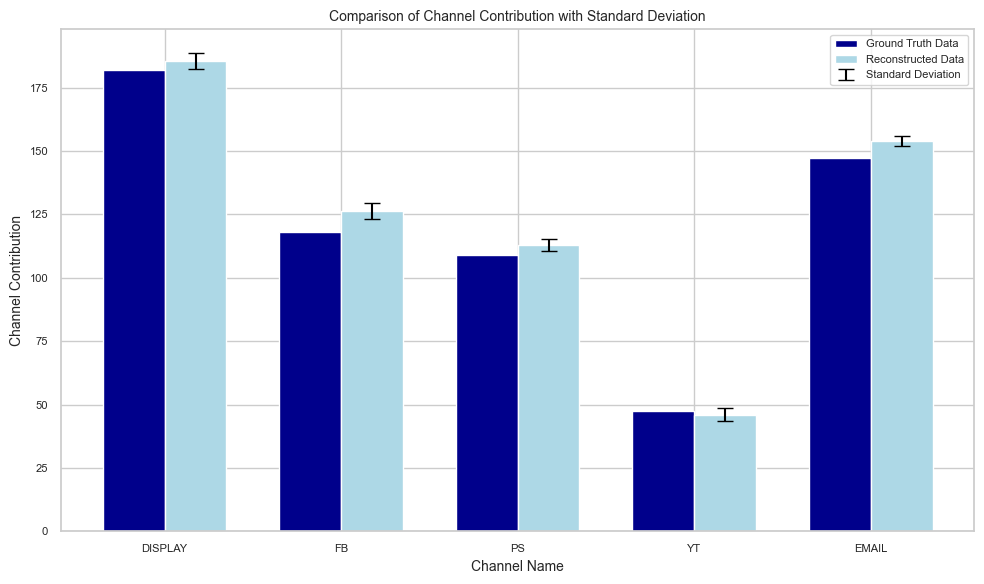

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_channel_comparison(ground_truth_data, reconstructed_data, std_dev_data):
    # Create DataFrames from input data
    df_ground_truth = pd.DataFrame(ground_truth_data)
    df_reconstructed = pd.DataFrame(reconstructed_data)
    df_std_dev = pd.DataFrame(std_dev_data)

    # Ensure the order of channels is consistent
    df_reconstructed = df_reconstructed.set_index('channel_name').reindex(df_ground_truth['channel_name']).reset_index()
    df_std_dev = df_std_dev.set_index('channel_name').reindex(df_ground_truth['channel_name']).reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))

    # Bar width
    bar_width = 0.35

    # Set positions of bars on X axis
    r1 = range(len(df_ground_truth))
    r2 = [x + bar_width for x in r1]

    # Create bars for the ground truth dataset
    plt.bar(r1, df_ground_truth['total_conversions'], color='darkblue', width=bar_width, label='Ground Truth Data')

    # Create bars for the reconstructed dataset
    plt.bar(r2, df_reconstructed['total_conversions'], color='lightblue', width=bar_width, label='Reconstructed Data')

    # Add error bars for the reconstructed data using standard deviation
    plt.errorbar(r2, df_reconstructed['total_conversions'], yerr=df_std_dev['total_conversions'],
                 fmt='none', color='black', capsize=6, label='Standard Deviation')

    # Add labels and title
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)  

    plt.xlabel('Channel Name', fontsize=10)
    plt.ylabel('Channel Contribution', fontsize=10)
    plt.xticks([r + bar_width / 2 for r in range(len(df_ground_truth))], df_ground_truth['channel_name'])
    plt.title('Comparison of Channel Contribution with Standard Deviation', fontsize=10)

    # Add legend
    plt.legend(fontsize=8)

    # Show the plot
    plt.tight_layout()
    plt.show()


# Call the function to plot
plot_channel_comparison(df_sim, mean_df, std_df)


You may add more figures if you want.

# END

This is the end of the notebook. Main codes are recorded here for you to reimplement out reconstruction method.

For more information, please check our paper!